In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

### Fit (and tune) Various Models

#### MODEL: ordinary least squares

In [5]:
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 4934, 'TN': 5074, 'FP': 4949, 'FN': 5043, 'Accuracy': 0.5004, 'Precision': 0.4992411211170697, 'Recall': 0.49453743610303696, 'desc': 'ols_train'}


#### MODEL: SVM, linear

In [6]:
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


#### MODEL: logistic regression

In [7]:
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


#### MODEL: Naive Bayes

In [8]:
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9565, 'TN': 9865, 'FP': 158, 'FN': 412, 'Accuracy': 0.9715, 'Precision': 0.9837498714388563, 'Recall': 0.958705021549564, 'desc': 'nbs_train'}


#### MODEL: Perceptron

In [9]:
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


#### MODEL: Ridge Regression Classifier

In [10]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


#### MODEL: Random Forest Classifier

In [11]:
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9977, 'Neg': 10023, 'TP': 6458, 'TN': 5904, 'FP': 4119, 'FN': 3519, 'Accuracy': 0.6181, 'Precision': 0.6105701049446913, 'Recall': 0.6472887641575624, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

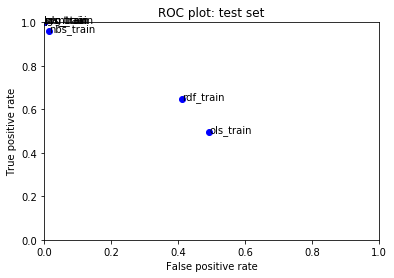

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### Looking at reviews based on their classification
Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well.

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:
38
I rented the dubbed-English version of Lensman, hoping that since it came from well-known novels it would have some substance. While there were hints of substance in the movie, it mostly didn't rise above the level of kiddie cartoon. Maybe the movie was a bad adaptation of the book, or it lost a lot in the dubbed version. Or maybe even the source novels were lightweight. But for whatever reason, there wasn't much there.<br /><br />I noticed lots of details that were derivative, sloppy, poorly dramatized, or otherwise deficient. Some examples: The opening scenes looked borrowed from the 2001 \star gate\" scene and the Star Wars image of hyperspace. The robot on the harvester looked like an anthropomorphized \"R2-D2\".<br /><br />It starts out trying to borrow its comic relief style of Star Wars, but mercifully (since the humor doesn't work) gives up on comedy and plays it serious. In that sense, it's superior to the Star Wars franchise, which started with

## Look at performance on the test set

#### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1203, 'TN': 1263, 'FP': 1214, 'FN': 1320, 'Accuracy': 0.4932, 'Precision': 0.4977244517997518, 'Recall': 0.4768133174791914, 'desc': 'ols_test'}


#### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2120, 'TN': 2073, 'FP': 404, 'FN': 403, 'Accuracy': 0.8386, 'Precision': 0.8399366085578447, 'Recall': 0.8402695204122077, 'desc': 'svm_test'}


#### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2129, 'TN': 2052, 'FP': 425, 'FN': 394, 'Accuracy': 0.8362, 'Precision': 0.8335943617854347, 'Recall': 0.843836702338486, 'desc': 'lgs_test'}


#### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1865, 'TN': 1833, 'FP': 644, 'FN': 658, 'Accuracy': 0.7396, 'Precision': 0.7433240334794738, 'Recall': 0.7391993658343242, 'desc': 'nbs_test'}


#### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2126, 'TN': 2051, 'FP': 426, 'FN': 397, 'Accuracy': 0.8354, 'Precision': 0.8330721003134797, 'Recall': 0.8426476416963932, 'desc': 'prc_test'}


#### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2062, 'FP': 415, 'FN': 343, 'Accuracy': 0.8484, 'Precision': 0.8400770712909441, 'Recall': 0.8640507332540627, 'desc': 'rdg_test'}


#### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1617, 'TN': 1513, 'FP': 964, 'FN': 906, 'Accuracy': 0.626, 'Precision': 0.6265013560635413, 'Recall': 0.6409036860879905, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

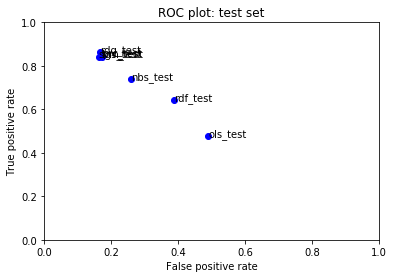

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### Models accuracy before introducing changes:

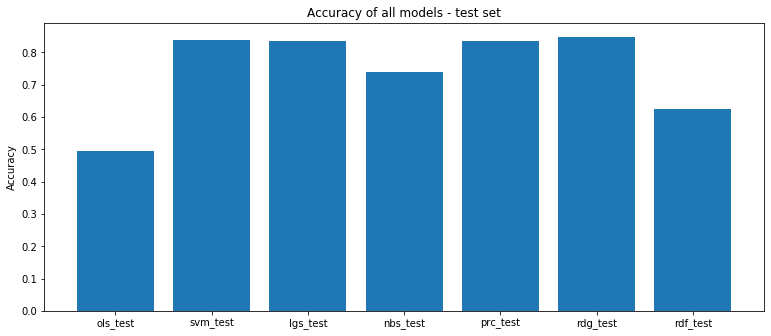

In [23]:
# Bar chart comparing the performance of the models on the test set before introducing changes
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

accuracy = []
description = []

for fit in fits:
    accuracy.append(fit.performance_measures['Accuracy'])
#     print(fit.performance_measures['Accuracy'], fit.performance_measures['desc'])
    description.append(fit.performance_measures['desc'])

# plot the performances as a bar chart
fig = plt.figure(figsize=[10, 4])
ax = fig.add_axes([0,0,1,1])
plt.bar(description, accuracy, align="center")
plt.ylabel('Accuracy')
plt.title('Accuracy of all models - test set')

plt.show()

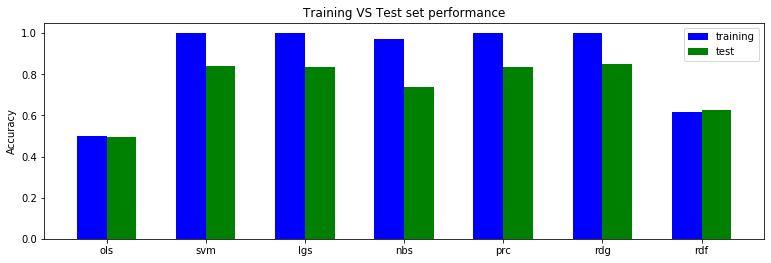

In [24]:
# Grouped bar chart comparing training and test set performance of the models
fits_train = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits_test = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

accuracy_train = []
description = []
for fit in fits_train:
    accuracy_train.append(fit.performance_measures['Accuracy'])
    fit.performance_measures['desc'] = fit.performance_measures['desc'].split('_')[0]
    description.append(fit.performance_measures['desc'])
    
accuracy_test = []
for fit in fits_test:
    accuracy_test.append(fit.performance_measures['Accuracy'])

width = 0.3
x = np.arange(len(description))

fig = plt.figure(figsize=[10, 3])
ax = fig.add_axes([0,0,1,1])

ax.bar(x, accuracy_train, color='b', width=width, label="training")
ax.bar(x + width, accuracy_test, color='g', width=width, label="test")

ax.set_ylabel('Accuracy')
ax.set_title('Training VS Test set performance')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(description)
ax.legend()


plt.show()

